# Import packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow import keras
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Training data 


## Train variants 

In [3]:
train_variants = pd.read_csv("/content/gdrive/MyDrive/Kaggle/msk-redefining-cancer-treatment/training_variants")
print('Number of data points : ', train_variants.shape[0])
print('Number of features : ', train_variants.shape[1])
print('Features : ', train_variants.columns.values)
train_variants.head()


Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


training_variants is a comma separated file containing the description of the genetic mutations used for training.
* ID : the id of the row used to link the mutation to the clinical evidence
* Gene : the gene where this genetic mutation is located
* Variation : the aminoacid change for this mutations
* Class : 1-9 the class this genetic mutation has been classified on

In [4]:
# Count of Unique Values of Gene
train_variants["Gene"].value_counts()

BRCA1    264
TP53     163
EGFR     141
PTEN     126
BRCA2    125
        ... 
ASXL1      1
SDHC       1
RNF43      1
MYOD1      1
FANCC      1
Name: Gene, Length: 264, dtype: int64

We have 264 different genes

In [5]:
# Count of Unique Values of Variation
train_variants["Variation"].value_counts()

Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
                        ..
E525K                    1
R99P                     1
R11K                     1
D820E                    1
S1715N                   1
Name: Variation, Length: 2996, dtype: int64

We have 2996 variation 

In [6]:
#checking number of unique values for 'Gene+Variation' combinations
G_V = train_variants.copy()
G_V['gene_and_variation']=train_variants['Gene']+' '+train_variants['Variation']
G_V.head()
G_V['gene_and_variation'].value_counts().head()

FGFR2 FGFR2-FAM76A Fusion    1
BRCA1 L1780P                 1
SMAD4 Y513A                  1
PDGFRB V665A                 1
KRAS P34L                    1
Name: gene_and_variation, dtype: int64

All combinations 'Gene + Variation' in these datasets are unique

In [7]:
train_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

This is descrete data so it is classification problem and since there are multiple descrete output possible so we can call it Multi class classification problem

In [8]:
# detect missing values 
train_variants.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

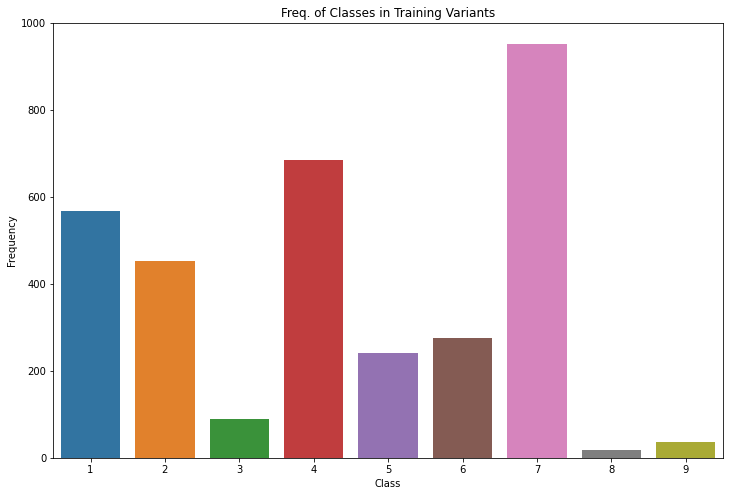

In [9]:
# plot Distribution of class
plt.figure(figsize=(12,8))
ax = sns.countplot(x="Class", data=train_variants)
plt.ylabel('Frequency'); plt.xlabel('Class')
plt.title('Freq. of Classes in Training Variants')
plt.show()

Classes seem very imbalanced

Genes that has highest number of occurrences in each class

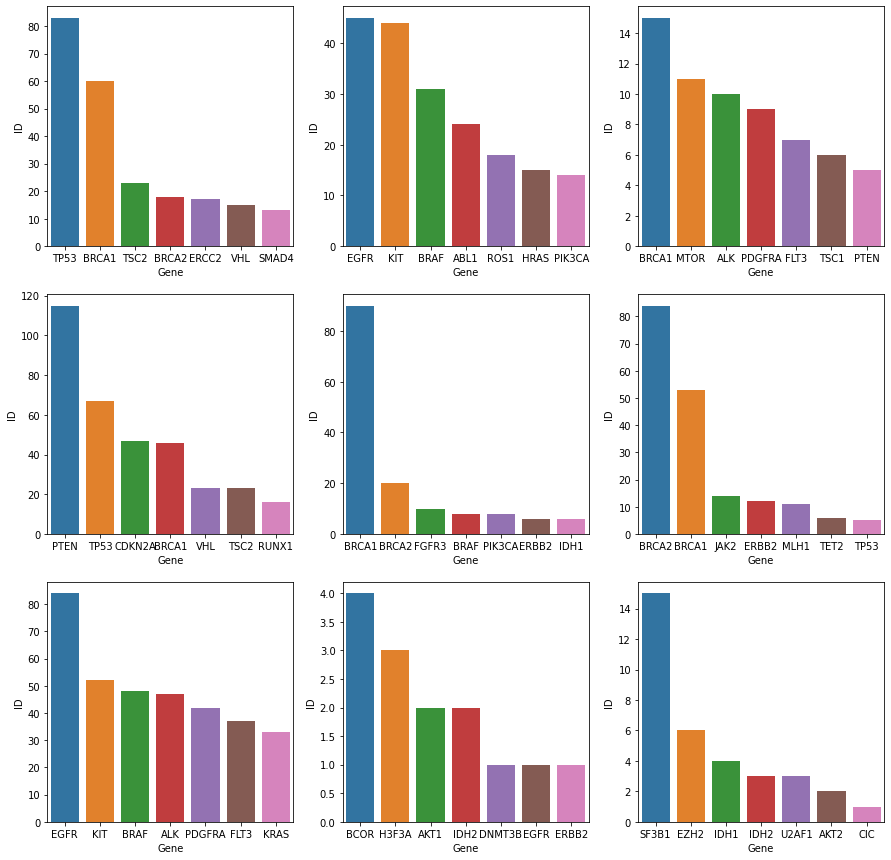

In [10]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = train_variants[train_variants["Class"]==((i*3+j)+1)].groupby('Gene')["ID"].count().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('ID', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="ID", data=sorted_gene_group_top_7, ax=axs[i][j])



Some points we can conclude from these graphs:

* BRCA1 is highly dominating Class 5
* SF3B1 is highly dominating Class 9
* BRCA1 and BRCA2 are dominating Class 6



## Train text

In [11]:
train_text = pd.read_csv("/content/gdrive/MyDrive/Kaggle/msk-redefining-cancer-treatment/training_text",sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
# Ragou's data
#train_text = pd.read_csv("/content/gdrive/MyDrive/Kaggle/msk-redefining-cancer-treatment/new_data_clean.txt",sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
print('Number of data points : ', train_text.shape[0])
print('Number of features : ', train_text.shape[1])
print('Features : ', train_text.columns.values)
train_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'Text']


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


train_text is double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. 
* ID (the id of the row used to link the clinical evidence to the genetic mutation)
* Text (the clinical evidence used to classify the genetic mutation)

In [12]:
train_text.Text.nunique()

1920

In [13]:
#count_text = train_text.copy()
train_text.loc[:, 'Text_count']  = train_text["Text"].apply(lambda x: len( str(x).split()))
train_text.head()


,ID,Text,Text_count
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,6089
1,1,Abstract Background Non-small cell lung canc...,5756
2,2,Abstract Background Non-small cell lung canc...,5756
3,3,Recent evidence has demonstrated that acquired...,5572
4,4,Oncogenic mutations in the monomeric Casitas B...,6202


# Preprocessing 

In [14]:
# remove stopwords: the,a,an etc.
nltk.download("stopwords")
from nltk.corpus import stopwords
sw = stopwords.words("english")

def pre_processing(data):
  # lowercase text
  data = data.apply(lambda x: " ".join(i.lower() for i in  str(x).split()))
  # remove numeric values
  data = data.str.replace("\d","")
  # remove punctuations
  data = data.str.replace("[^\w\s]","")
  # remove stopwords: the,a,an etc.
  data = data.apply(lambda x: " ".join(i for i in x.split() if i not in sw))
  return data



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
train_text['Text']= pre_processing(train_text['Text'])


In [16]:
train_text.loc[:, 'Text_count']  = train_text['Text'].apply(lambda x: len( str(x).split()))
train_text.head()

,ID,Text,Text_count
0,0,cyclindependent kinases cdks regulate variety ...,3703
1,1,abstract background nonsmall cell lung cancer ...,3407
2,2,abstract background nonsmall cell lung cancer ...,3407
3,3,recent evidence demonstrated acquired uniparen...,3382
4,4,oncogenic mutations monomeric casitas blineage...,3762


# Merge Datasets

In [17]:
df_merge = pd.merge(train_variants,train_text, on="ID",how="left")
df_merge.head()

,ID,Gene,Variation,Class,Text,Text_count
0,0,FAM58A,Truncating Mutations,1,cyclindependent kinases cdks regulate variety ...,3703
1,1,CBL,W802*,2,abstract background nonsmall cell lung cancer ...,3407
2,2,CBL,Q249E,2,abstract background nonsmall cell lung cancer ...,3407
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...,3382
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas blineage...,3762




There are multiple rows with similar texts let us check how many of them are unique and whether all similar texts belongs to same class

In [18]:
df_merge['Text'] = df_merge['Text'].astype(str)

In [19]:
count_grp = df_merge.groupby('Class')["Text_count"]
count_grp.describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
1,568.0,5743.426056,3965.451812,1.0,3057.00,4557.5,7514.50,31380.0
2,452.0,5697.924779,4690.364156,71.0,2570.25,4224.0,7502.25,38422.0
3,89.0,4109.505618,2217.860605,1123.0,2659.00,3382.0,4607.00,16559.0
4,686.0,5487.255102,4416.365220,28.0,2799.25,3908.0,7050.25,26508.0
5,242.0,4499.347107,2257.312406,113.0,3076.00,4126.0,5720.00,14670.0
6,275.0,4195.363636,2381.260474,1.0,2655.00,3720.0,4862.00,14856.0
7,953.0,6988.057712,6105.308862,1.0,3025.00,5052.0,8843.00,48090.0
8,19.0,6741.052632,3527.127577,1297.0,3466.00,6882.0,9835.00,12808.0
9,37.0,8058.189189,6427.903580,728.0,2960.00,7010.0,10078.00,27837.0


In [20]:
df_merge[df_merge["Text_count"]==1.0]

,ID,Gene,Variation,Class,Text,Text_count
1109,1109,FANCA,S1088F,1,nan,1
1277,1277,ARID5B,Truncating Mutations,1,nan,1
1407,1407,FGFR3,K508M,6,nan,1
1639,1639,FLT1,Amplification,6,nan,1
2755,2755,BRAF,G596C,7,nan,1


we can see there are some entries without any text data

In [21]:
# Fill NaN values with Gene & Variation 
df_merge.loc[df_merge["Text_count"]==1.0,"Text"] = df_merge["Gene"] + " " + df_merge["Variation"]

Get distribution of text count for each class

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 61.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 54.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 37.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 65.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 52.5% of the points cannot be placed; y

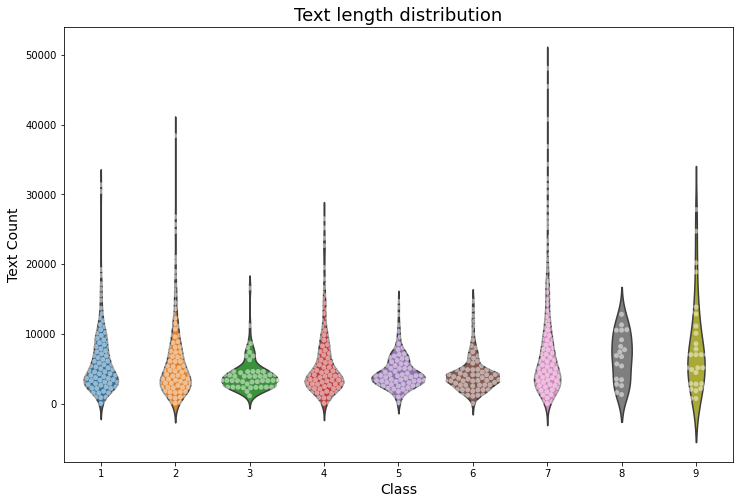

In [22]:
plt.figure(figsize=(12,8))
gene_count_grp = df_merge.groupby('Gene')["Text_count"].sum().reset_index()
sns.violinplot(x="Class", y="Text_count", data=df_merge, inner=None)
sns.swarmplot(x="Class", y="Text_count", data=df_merge, color="w", alpha=.5);
plt.ylabel('Text Count', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Text length distribution", fontsize=18)
plt.show()


 All classes have most counts in between 0 to 20000. Just as expected

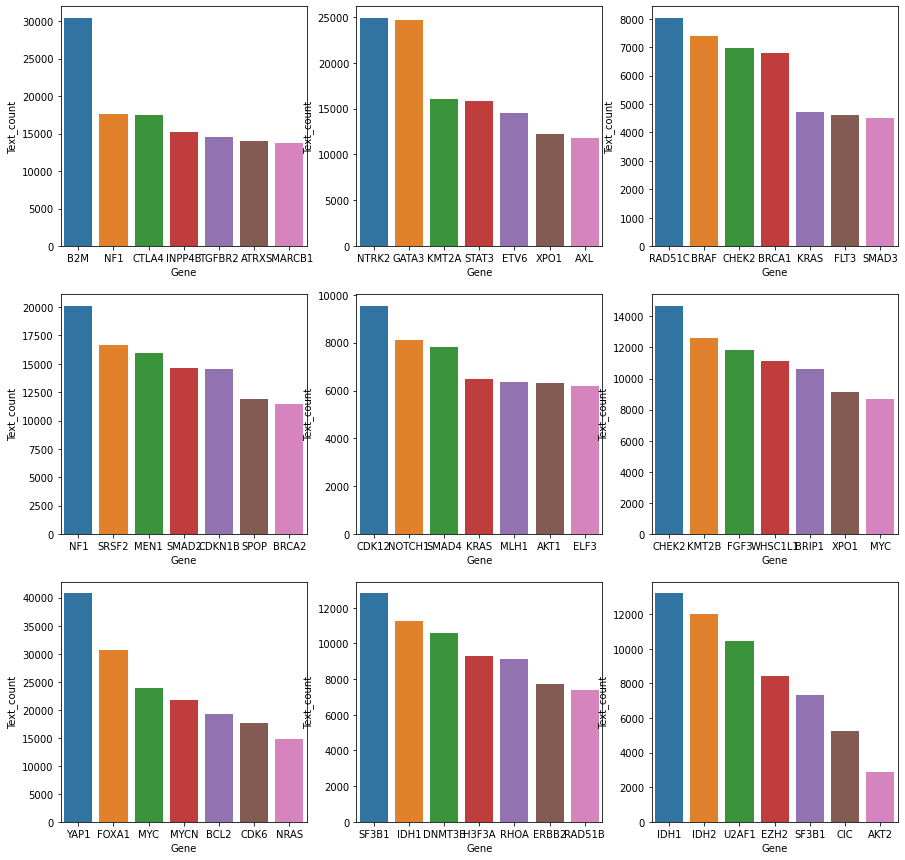

In [23]:
# how many times the gene is cited in the articles in each class
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = df_merge[df_merge["Class"]==((i*3+j)+1)].groupby('Gene')["Text_count"].mean().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('Text_count', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="Text_count", data=sorted_gene_group_top_7, ax=axs[i][j])

# Text Embedding

In [24]:
# Use the Keras tokenizer, vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary)
# the maximum number of words to keep, based on word frequency.
num_words = 2000 
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_merge['Text'].values) # Updates internal vocabulary based on a list of texts.

In [25]:
tokenizer.word_index # get the index of each word

{'mutations': 1,
 'cells': 2,
 'cell': 3,
 'al': 4,
 'et': 5,
 'mutation': 6,
 'fig': 7,
 'figure': 8,
 'cancer': 9,
 'p': 10,
 'patients': 11,
 'protein': 12,
 'activity': 13,
 'expression': 14,
 'brca': 15,
 'mutant': 16,
 'also': 17,
 'variants': 18,
 'c': 19,
 'domain': 20,
 'using': 21,
 'tumor': 22,
 'kinase': 23,
 'data': 24,
 'gene': 25,
 'analysis': 26,
 'b': 27,
 'mutants': 28,
 'tumors': 29,
 'table': 30,
 'may': 31,
 'activation': 32,
 'wildtype': 33,
 'dna': 34,
 'two': 35,
 'binding': 36,
 'egfr': 37,
 'results': 38,
 'shown': 39,
 'genes': 40,
 'proteins': 41,
 'one': 42,
 'used': 43,
 'exon': 44,
 'identified': 45,
 'human': 46,
 'found': 47,
 'growth': 48,
 'study': 49,
 'signaling': 50,
 'clinical': 51,
 'levels': 52,
 'lines': 53,
 'functional': 54,
 'observed': 55,
 'however': 56,
 'studies': 57,
 'kit': 58,
 'assay': 59,
 'function': 60,
 'different': 61,
 'three': 62,
 'residues': 63,
 'supplementary': 64,
 'treatment': 65,
 'phosphorylation': 66,
 'cases': 67,
 '

words contain al et => no significant word 

must take the gene, mutation, variation ... 



In [26]:
# Pad the data 
X = tokenizer.texts_to_sequences(df_merge['Text'].values) # Transforms each text in texts to a sequence of integers, Only top num_words most frequent words will be taken into account.
X = pad_sequences(X, maxlen=2000) # transforms a lists of integers into a 2D Numpy array of shape (num_samples, num_timesteps)


# Split the data 

## For machine learning Models 

In [27]:
Y_M = df_merge.Class
XM_train, XM_test, YM_train, YM_test = train_test_split(X, Y_M, test_size = 0.2, random_state = 42, stratify=Y_M)
print(XM_train.shape, YM_train.shape)
print(XM_test.shape, YM_test.shape)

(2656, 2000) (2656,)
(665, 2000) (665,)


## For Deep Learning Model

In [28]:
Y_D = pd.get_dummies(df_merge['Class']).values
XD_train, XD_test, YD_train, YD_test = train_test_split(X, Y_D, test_size = 0.2, random_state = 42, stratify=Y_D)
print(XD_train.shape, YD_train.shape)
print(XD_test.shape, YD_test.shape)

(2656, 2000) (2656, 9)
(665, 2000) (665, 9)


# Machine Learning Model

## Random Forest

as a Baseline

In [29]:
from sklearn.ensemble import RandomForestClassifier

def predict(x_train, y_train, x_test):
    clf = RandomForestClassifier(n_jobs=3, # number of jobs to run in parallel
                                n_estimators=100, # number of trees in the forest
                                criterion='entropy', # measure the quality of a split, 'entropy' for the information gain
                                random_state=300) # Controls the randomness of the bootstrapping of the samples and the sampling of the features to consider when looking for the best split at each node 

    clf.fit(x_train, y_train)
    return clf.predict(x_test)


### Prediction

In [30]:
predicted = predict(XM_train, YM_train, XM_test)

accuracy_score(YM_test, predicted)


0.5684210526315789

### Confusion matrix

A confusion matrix is a way to express how many of a classifier’s predictions were correct, and when incorrect, where the classifier got confused.

Rows represent the true labels and the columns represent predicted labels.
The column tells us what the classifier predicted, and the row tells us what the right label was

In [31]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(YM_test, predicted)
print(cm)

[[ 55   0   0  14   7   5  33   0   0]
 [  2  25   0   1   5   0  58   0   0]
 [  2   0   8   2   2   0   4   0   0]
 [ 14   0   3  74   4   2  40   0   0]
 [  9   1   1   8  12   1  16   0   0]
 [  5   1   1   4   2  28  14   0   0]
 [  2   7   5   2   3   0 172   0   0]
 [  0   0   0   0   0   0   2   0   2]
 [  0   0   0   0   0   0   3   0   4]]


### Plot confusion matrix 

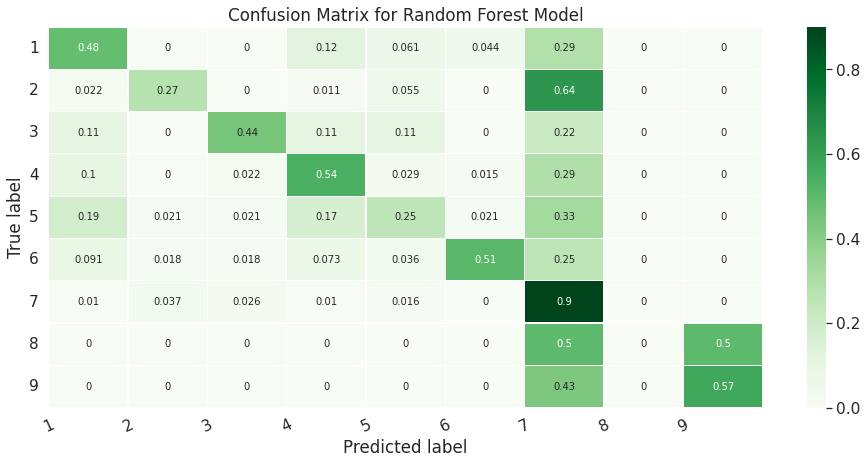

In [32]:
# Reshape confusion matrix data
matrix = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['1', '2', '3', 
               '4', '5', '6', 
               '7', '8', '9']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()


The model don't predict class 8, it gives a good prediction of class 1, 4, 6,7 

## Naive Bayes

In [33]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()

Naive.fit(XM_train, YM_train)# predict the labels on validation dataset

predictions_NB = Naive.predict(XM_test)# Use accuracy_score function to get the accuracy

print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, YM_test)*100)

Naive Bayes Accuracy Score ->  42.857142857142854


## SVM 

In [34]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier

SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

SVM.fit(XM_train, YM_train)# predict the labels on validation dataset

predictions_SVM = SVM.predict(XM_test)# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, YM_test)*100)

SVM Accuracy Score ->  51.127819548872175


# Deep Learning Model

## LSTM

### Build Model

In [35]:
num_words = 2000
embed_dim = 128
lstm_out = 64

model = Sequential(
    [
        Embedding(num_words, embed_dim, input_length = X.shape[1]),
        LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2),
        Dense(32, activation = "relu"),
        Dense(9,activation='softmax')
    ]
)

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 128)         256000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 297       
Total params: 307,785
Trainable params: 307,785
Non-trainable params: 0
_________________________________________________________________
None


### Plot the model 

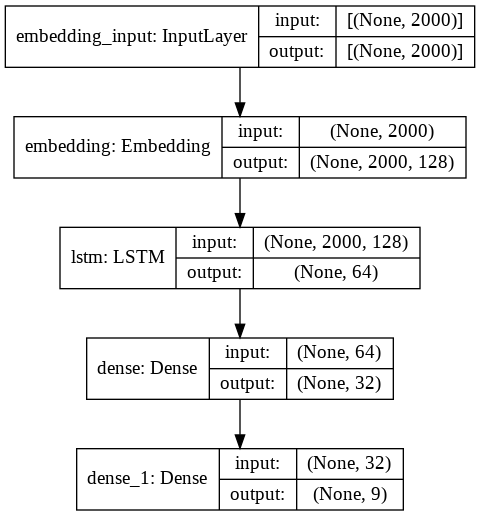

In [36]:
keras.utils.plot_model(model, "my_first_model_shapes.png", show_shapes= True)

### Model Training 

In [ ]:
batch_size = 32
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')
history = model.fit(XD_train, YD_train, epochs=5, batch_size=batch_size, validation_split=0.2, callbacks=[ckpt_callback])

In [38]:
loss, accuracy = model.evaluate(XD_train, YD_train, verbose=False)
print("Training Accuracy: >%.3f"  % (accuracy * 100.0))

Training Accuracy: >74.021


### Testing 

In [40]:
loss, accuracy = model.evaluate(XD_test, YD_test, verbose=False)
print("Testing Accuracy:  >%.3f"  % (accuracy * 100.0))

Testing Accuracy:  >57.143


### Plot Model loss and accuracy

In [41]:
# list all data history 
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<function matplotlib.pyplot.show>

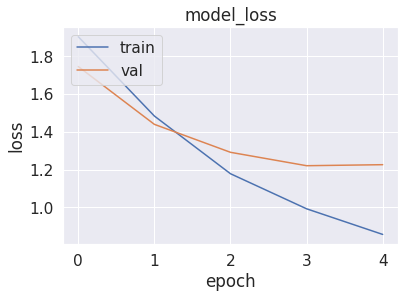

In [42]:
# visualize training and validation losses  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show 

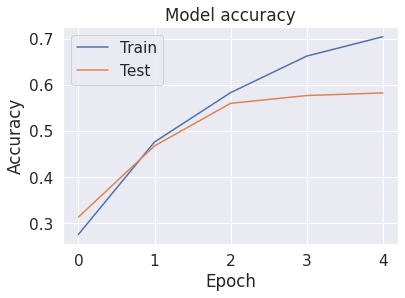

In [43]:
# visualize training and validation accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## CNN

### Model building 

In [44]:
cnnmodel = Sequential()
cnnmodel.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
cnnmodel.add(Conv1D(64, 5, activation='relu'))
cnnmodel.add(GlobalMaxPooling1D())
cnnmodel.add(Dense(10, activation='relu'))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(9, activation='softmax'))
cnnmodel.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
cnnmodel.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 128)         256000    
_________________________________________________________________
conv1d (Conv1D)              (None, 1996, 64)          41024     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
_________________________________________________________________
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 99        
Total params: 297,773
Trainable params: 297,773
Non-trainable params: 0
________________________________________________

### Plot the model 

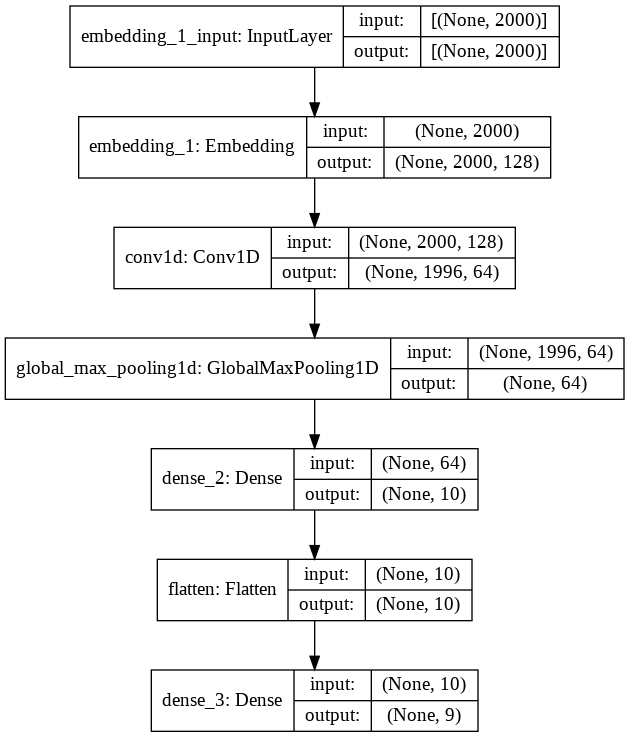

In [45]:
keras.utils.plot_model(cnnmodel, "my_first_model_shapes.png", show_shapes= True)

### Model Training 

In [46]:
hiscnn = cnnmodel.fit(XD_train, YD_train,
                     epochs=5,
                     verbose=False,
                     validation_split=0.2,
                     batch_size=32)
loss, accuracy = cnnmodel.evaluate(XD_train, YD_train, verbose=False)
print("Training Accuracy: >%.3f"  % (accuracy * 100.0))


Training Accuracy: >59.789


### Model Testing 

In [47]:
loss, accuracy = cnnmodel.evaluate(XD_test, YD_test, verbose=False)
print("Testing Accuracy:  >%.3f"  % (accuracy * 100.0))

Testing Accuracy:  >53.083


## Plot Model loss and accuracy

In [48]:
# list all data history 
print(hiscnn.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<function matplotlib.pyplot.show>

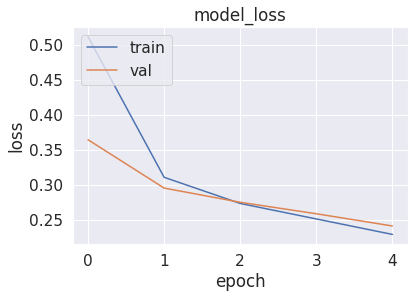

In [49]:
# visualize training and validation losses  
plt.plot(hiscnn.history['loss'])
plt.plot(hiscnn.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show 

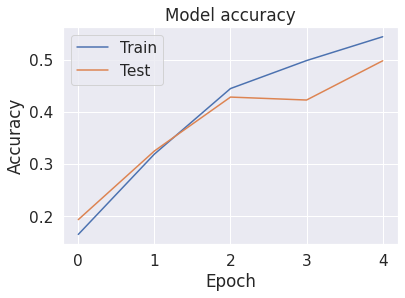

In [50]:
# visualize training and validation accuracies
plt.plot(hiscnn.history['accuracy'])
plt.plot(hiscnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()